### Load Test Data and Trained APG Sampler

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
# from objectives import apg_objective
from data import setup_data_loader
# from resampler import Resampler
from utils import init_models, load_models
device = 'cuda:1'
model_name, data = 'APG', 'movingmnist'
num_digits, batch_size, z_what_dim = 3, 5, 10
sample_size, num_sweeps = 1, 10
# exp_name = '{}_d={}-3_budget=60_sweeps=6_z={}_lr=0.0002_seed=1'.format(model_name, data, z_what_dim)
data_args = {'data': data,
             'batch_size': batch_size,
             'train': False,
             'timesteps': 10,
             'num_digits': num_digits,
             'dv': 0.1,
             'frame_size': 96,
             'shuffle': False,
              }
test_loader, _, _, _ = setup_data_loader(**data_args)
network_args = {'model_name': model_name, 
                'device': device, 
                'frame_size': 96, 
                'digit_size': 28, 
                'num_hidden_location': 400, 
                'num_hidden_digit': 400, 
                'z_where_dim': 2, 
                'z_what_dim': z_what_dim,
                }
models = init_models(**network_args)
# load_models(models, exp_name, map_location=torch.device(device))

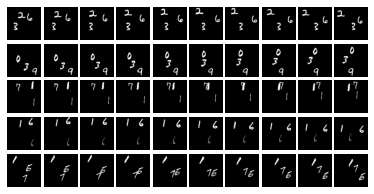

In [2]:
from utils import plot_samples
for images in test_loader:
    break
images.shape
plot_samples(images)

In [ ]:
from evaluation import viz_samples
resampler = Resampler('systematic', sample_size, device)
mnist_mean = torch.load('mnist_mean.pt').repeat(sample_size, batch_size, num_digits, 1, 1).to(device)
for b, images in enumerate(test_loader):
    images = images.squeeze(1).repeat(sample_size, 1, 1, 1).to(device)        
    metrics, modes = apg_objective(models, 
                                   images, 
                                   num_sweeps, 
                                   resampler, 
                                   mnist_mean, 
                                   ['loss_phi', 'loss_theta', 'ess', 'density'])
    break
viz_samples(images.squeeze(0).cpu(), modes, num_sweeps, num_digits, fs=2)

### Computing log joint across all methods

In [ ]:
from evaluation import density_all_instances
sample_size, num_sweeps = 100, 1
mnist_mean = torch.load('mnist_mean.pt').repeat(sample_size, batch_size, num_digits, 1, 1).to(device)
lf_step_size, lf_num_steps, bpg_factor = 1e-4, [10], 1
density_all_instances(models=models, 
                      device=device, 
                      data_loader=test_loader, 
                      sample_size=sample_size, 
                      num_digits=num_digits, 
                      num_sweeps=num_sweeps, 
                      z_where_dim=2, 
                      z_what_dim=z_what_dim, 
                      lf_step_size=lf_step_size, 
                      lf_num_steps=lf_num_steps, 
                      bpg_factor=bpg_factor,
                      mnist_mean=mnist_mean,
                      algo='hmc')

In [ ]:
%debug